In [1]:
# package imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker
import matplotlib
import matplotlib.gridspec as gridspec
import sklearn

import glob
import re
from sklearn.decomposition import PCA

Load and prep dataframe for sequence logo comparison

In [2]:

exp_7_learned_model_df = pd.read_csv('learned_models/learned_model_exp_7.csv')
exp_8_learned_model_df = pd.read_csv('learned_models/learned_model_exp_8.csv')

del exp_7_learned_model_df['Unnamed: 0']
del exp_8_learned_model_df['Unnamed: 0']

temp_exp7 = exp_7_learned_model_df[['val_A', 'val_C', 'val_G', 'val_T']].copy()
temp_exp8 = exp_8_learned_model_df[['val_A', 'val_C', 'val_G', 'val_T']].copy()

tmp_df7 = temp_exp7.copy()
tmp_df7.loc[:,:] = np.flipud(np.fliplr(tmp_df7.values))
tmp_df7 = tmp_df7.loc[0:49,:]
tmp_df7.columns = ['A','C','G','T']

tmp_df8 = temp_exp8.copy()
tmp_df8.loc[:,:] = np.flipud(np.fliplr(tmp_df8.values))
tmp_df8 = tmp_df8.loc[0:49,:]
tmp_df8.columns = ['A','C','G','T']


exp_7_learned_model_df_ER = pd.read_csv('learned_models/learned_model_exp_7_ER.csv')
exp_8_learned_model_df_ER = pd.read_csv('learned_models/learned_model_exp_8_ER.csv')

del exp_7_learned_model_df_ER['Unnamed: 0']
del exp_8_learned_model_df_ER['Unnamed: 0']

temp_exp7_ER = exp_7_learned_model_df_ER[['val_A', 'val_C', 'val_G', 'val_T']].copy()
temp_exp8_ER = exp_8_learned_model_df_ER[['val_A', 'val_C', 'val_G', 'val_T']].copy()

tmp_df7_ER = temp_exp7_ER.copy()
tmp_df7_ER.loc[:,:] = np.flipud(np.fliplr(tmp_df7_ER.values))
tmp_df7_ER = tmp_df7_ER.loc[0:49,:]
tmp_df7_ER.columns = ['A','C','G','T']

tmp_df8_ER = temp_exp8_ER.copy()
tmp_df8_ER.loc[:,:] = np.flipud(np.fliplr(tmp_df8_ER.values))
tmp_df8_ER = tmp_df8_ER.loc[0:49,:]
tmp_df8_ER.columns = ['A','C','G','T']

Load dfs for PCA comparisons

In [3]:
# Load models indictionary format
model_files = glob.glob('matrices_IM/model.mi.*.txt')
model_df_dict = {}
print('Loading %d models into model_df_dict...'%len(model_files))
for model_file in model_files:
    model_name = re.match('.*/model.mi.(.*).txt', model_file).group(1)
    model_df = pd.read_csv(model_file, sep='\t', index_col=0)
    
    # Crop to A element
    #model_df = model_df.iloc[14:34,:]
    
    model_df_dict[model_name] = model_df
    
# Get size of data
model_df_list = list(model_df_dict.values())
N = len(model_df_dict)
P = len(model_df_list[0].values.ravel())
print('N = %d, P = %d'%(N,P))
    
# Fill in data_df, which will be used for PCA
data_df = pd.DataFrame(data=np.zeros([N,P]), index=model_df_dict.keys())
for name, row in data_df.iterrows():
    tmp_df = model_df_dict[name].copy()
    vec = tmp_df.values.ravel()
    vec /= np.sqrt(np.sum(vec**2))
    row[:] = vec
data_cols = list(data_df.columns).copy()
    
# Parse names in data
pattern = '(exp.)_(ars[0-9]+)_([a-z0-9\-]+)_(.*)'
matches = [re.match(pattern,name) for name in data_df.index]

# Make sure all names match
for name in data_df.index:
    if not re.match(pattern,name):
        assert False, 'File name "%s" doesnt match pattern "%s"'%(name, pattern)

#data_df = data_df.loc[good_names,:]
data_df['exp'] = [m.group(1) for m in matches]
data_df['ars'] = [m.group(2) for m in matches]
data_df['strain'] = [m.group(3) for m in matches]
data_df['v'] = [m.group(4) for m in matches]
info_cols = ['ars','strain','exp','v'] 

# Rearrange cols and sort rows in data_df
data_df = data_df[info_cols + data_cols]
data_df.sort_values(by=['ars','strain','exp','v'], inplace=True)
data_df.head()

Loading 59 models into model_df_dict...
N = 59, P = 200


,ars,strain,exp,v,0,1,2,3,4,5,...,190,191,192,193,194,195,196,197,198,199
exp5_ars317_m1_v1,ars317,m1,exp5,v1,0.001198,-0.004835,-0.037613,0.041250,-0.048928,0.021596,...,-0.041243,0.054303,-0.001949,0.020094,-0.041776,0.023630,0.000686,-0.044879,0.019331,0.024862
exp6_ars317_m1_v1,ars317,m1,exp6,v1,-0.005935,-0.005282,-0.009159,0.020375,-0.011889,0.015429,...,-0.070147,0.103558,-0.021916,0.026686,-0.027872,0.023102,0.015533,-0.015920,-0.004768,0.005155
exp7_ars317_m1_v1,ars317,m1,exp7,v1,-0.000319,-0.004498,-0.016161,0.020978,-0.000897,0.012442,...,-0.068494,0.100187,-0.015534,0.026095,-0.022563,0.012002,0.025379,-0.008942,0.002345,-0.018782
exp6_ars317_m20_v1,ars317,m20,exp6,v1,-0.011431,0.007212,-0.012568,0.016788,-0.008803,0.013452,...,-0.067307,0.094878,-0.021761,0.021112,-0.031583,0.032232,0.018737,-0.005438,-0.005149,-0.008150
exp7_ars317_m20_v1,ars317,m20,exp7,v1,-0.007556,0.011626,-0.019669,0.015599,-0.009634,0.007529,...,-0.085628,0.104834,-0.019749,0.016894,-0.019128,0.021983,0.019971,-0.023066,0.020766,-0.017671


In [4]:
mutant_to_strain_dict = {'m1':'Y486Q', 'm20':'R478K', 'm21':'FY-AA', 
                         'm22':'FY-IQ', 'm23':'FY-YF', 'm3':'F485I', 
                         'm5':'N489A', 'm6':'N489W', 'm9':'R478A', 'wt':'wt'}

strain_to_mutant_dict = {'Y486Q':'m1', 'R478K':'m20', 
                         'FY-AA':'m21', 'FY-IQ':'m22', 
                         'FY-YF':'m23', 'F485I':'m3', 
                         'N489A':'m5', 'N489W':'m6', 
                         'R478A':'m9', 'wt':'wt'}

## To remove strains

In [5]:


library='ars416'
#data_df_wo_strains = data_df[data_df['ars']==library].copy()
data_df_wo_strains = data_df.copy()

data_df_wo_strains = data_df_wo_strains[
                    (data_df_wo_strains['strain']!=strain_to_mutant_dict['N489A']) & 
                    (data_df_wo_strains['strain']!=strain_to_mutant_dict['N489W']) &
                    (data_df_wo_strains['strain']!=strain_to_mutant_dict['R478A']) &
                    (data_df_wo_strains['strain']!=strain_to_mutant_dict['R478K'])
                  ]

In [5]:
data_df = data_df_wo_strains.copy()

NameError: name 'data_df_wo_strains' is not defined

['m1', 'm20', 'm21', 'm22', 'm23', 'm3', 'm5', 'm6', 'm9', 'wt']
There are 10 strains
['m1', 'm20', 'm21', 'm22', 'm23', 'm3', 'm5', 'm6', 'm9', 'wt']
There are 10 strains


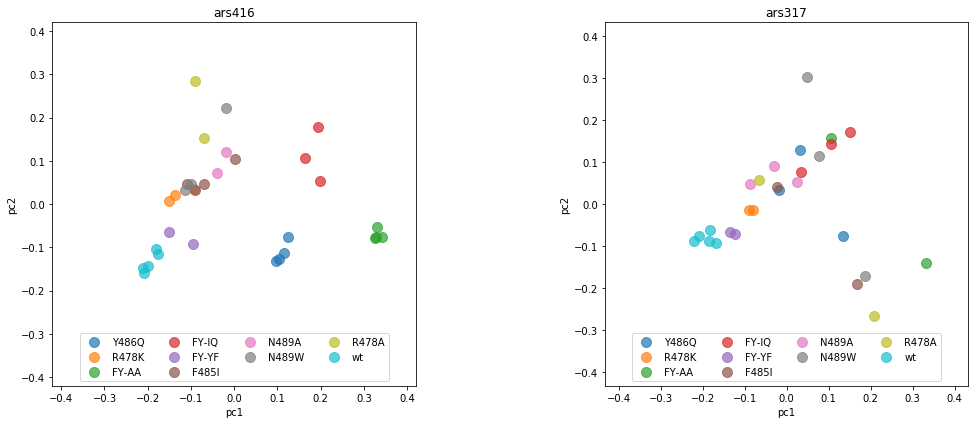

In [6]:


# Create figure
fig, axs = plt.subplots(1,2,figsize=[16,6])

#for panel_num, restrict in enumerate(['ars416','ars317', None]):
for panel_num, restrict in enumerate(['ars416','ars317']):
    # Set panel number
    ax = axs[panel_num]

    # Perform restriction
    if restrict=='ars416' or restrict=='ars317':
        tmp_df = data_df[data_df['ars']==restrict].copy()
    #else:
    #    tmp_df = data_df.copy()
        
    # Remove selected names
#     bad_indices = np.zeros(len(tmp_df)).astype(bool)
#     bad_indices |= np.array(['-' in name for name in tmp_df.index])
#     bad_indices |= np.array(['_all' in name for name in tmp_df.index])
#     tmp_df = tmp_df[~bad_indices]        

    # Do PCA
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(tmp_df.loc[:,data_cols])

    # Create pca_df with both pcs and info
    #pattern = '(exp.)_(ars[0-9]+)_([a-z0-9]+)_(.*)'
    pattern = '(exp.)_(ars[0-9]+)_([a-z0-9\-]+)_(.*)'
    pca_cols = ['pc1','pc2']
    pca_df = pd.DataFrame(data=pcs, columns=pca_cols, index=tmp_df.index)
    pca_df = pd.concat([tmp_df[info_cols], pca_df], axis=1)

    # Create sorted list of strains
    strain_list = list(set(pca_df['strain']))
    strain_list.sort()
    print(strain_list)
    print('There are %d strains'%len(strain_list))

    # Get default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #colors = colors + ['k']

    # Cycle through strains
    for i, strain in enumerate(strain_list):
        # Get indices
        indices = (pca_df['strain']==strain) 
        
        tmp2_df = pca_df.loc[indices,:]
#         print('Plotting strain',strain)
#         if strain=='m1' and i==0:
#             colors[i] = 'red'
#         print(tmp2_df.index)
        #ax.scatter(x=tmp2_df['pc1'],y=tmp2_df['pc2'], label=strain, color=colors[i], alpha=.7, s=100)
        #ax.scatter(x=tmp2_df['pc1'],y=tmp2_df['pc2'], label=strain, alpha=.7, s=100)
        ax.scatter(x=tmp2_df['pc1'],y=tmp2_df['pc2'], 
                   label=mutant_to_strain_dict[strain],
                   color=colors[i], alpha=.7, s=100)
        

    # Set lims
    xs = pca_df['pc1'].values
    ys = pca_df['pc2'].values
    rmax = max(np.sqrt(xs**2+ys**2))
    lims = [-1.2*rmax, +1.2*rmax]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
        
    # Style plot
    if restrict is not None:
        ax.set_title(restrict)
    else:
        ax.set_title('ars416 and ars317')
    #ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.4), ncol=4)
    ax.legend(loc='lower center', ncol=4)
    ax.set_xlabel('pc1')
    ax.set_ylabel('pc2')
    
plt.tight_layout()
#plt.savefig('pca_ER.png')

In [24]:
#data_df['LM'] = ['IM' for _ in range(len(data_df))] 

In [7]:
#data_df.to_csv('PCA_IM.csv')
len(pca_df)

27

### Draw Sequences logos only

Text(-1,0.7,'(b)')

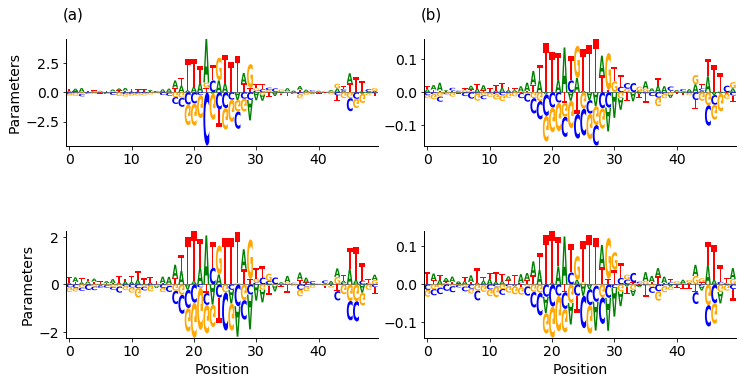

In [8]:
dfs_list = [-tmp_df7_ER,tmp_df7,-tmp_df8_ER,tmp_df8]
fig = plt.figure(figsize=[12,5.5])
gs = gridspec.GridSpec(2,2,hspace=0.8,wspace=0.15)

plt.tick_params(axis='both', which='major', labelsize=14)
column_index = 0
row_index = 0
for logo in dfs_list:
    
                  
    ax = plt.subplot(gs[column_index,row_index ])
    ax.tick_params(labelsize=14)
    current_logo = logomaker.Logo(logo, ax=ax, show_spines=False)
    
    current_logo.style_spines(spines=['left', 'bottom'], visible=True)
    

    
    if row_index==0:        
        ax.set_ylabel('Parameters',fontsize=14)
    if column_index==1:
        ax.set_xlabel('Position',fontsize=14)
    
    if row_index ==1:
        column_index=1
        row_index=0
    else:
        row_index+=1
#plt.tight_layout()    
plt.text(-58.5, 0.7, '(a)', fontsize=15)
plt.text(-1, 0.7, '(b)', fontsize=15)

#plt.savefig('Fig_S1.png')


### Draw PCA IM

59
59
exp1_ars416_m21 -> exp9_ars416_m21c2.txt
exp2_ars416_m21 -> exp9_ars416_m21c6.txt


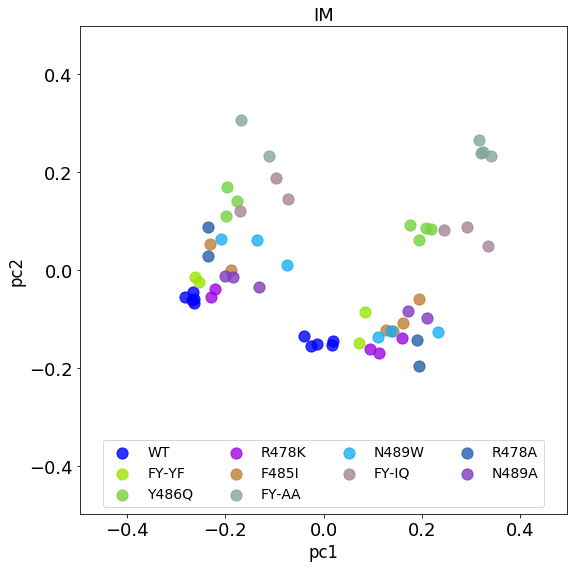

In [16]:
# Create figure
fig, ax = plt.subplots(1,1,figsize=[8,8])

# Choose which dots to plot
tmp_df = data_df.copy()
indices = np.ones(N).astype(bool)

# Choose ars
#tmp_df = tmp_df[tmp_df['ars']=='ars416']
tmp_df = data_df.copy()

# Remove selected names
bad_indices = np.zeros(len(tmp_df)).astype(bool)
bad_indices |= np.array(['-' in name for name in tmp_df.index])
bad_indices |= np.array(['_all' in name for name in tmp_df.index])
tmp_df = tmp_df[~bad_indices]

print(len(tmp_df))


# Create plotting groups
tmp_df['group'] = tmp_df['strain']


indices = np.array(['wt' in strain for strain in tmp_df['strain']]) 
tmp_df.loc[indices,'group']='wt'

indices = np.array(['m22' in strain for strain in tmp_df['strain']]) 
tmp_df.loc[indices,'group']='m22'


indices = np.array(['m1' in strain for strain in tmp_df['strain']]) 
tmp_df.loc[indices,'group']='m1'

indices = np.array(['m3' in strain for strain in tmp_df['strain']]) 
tmp_df.loc[indices,'group']='m3'



# Restrict to selected groups
#groups_to_show = ['wt', 'm1', 'm3', 'm5', 'm6', 'm9', 'm20', 'm21', 'm22', 'm23']
groups_to_show = ['wt', 'm1', 'm3', 'm5', 'm6', 'm9', 'm20', 'm21', 'm22', 'm23']

#mutant_labels = ['Y486Q','R478K', 'FY-AA','FY-IQ','FY-YF','F485I', 'N489A','N489W','R478A','WT']
mutant_labels = ['WT','FY-YF','Y486Q','R478K','F485I', 'FY-AA','N489W','FY-IQ', 'R478A','N489A',]


# randomly generated
colors_list = [ 
                [0.0, 0.0, 1.0], # WT
                [0.61252607, 0.89187607, 0.02175532],    # F485Y,Y486F
                [0.45630455, 0.82612284, 0.25137413],    # Y486Q
                [0.61252607, 0.02175532, 0.89187607],    # R478K
                [0.74880388, 0.49850701, 0.22479665],    # F485I
                [0.51313824, 0.65039718, 0.60103895],    # F485A,Y486A

                [0.08833981, 0.68535982, 0.95339335],    # N489W
                [0.65039718, 0.51313824, 0.60103895],    # F485I,Y486Q
                
                [0.14217005, 0.37334076, 0.67413362],    # R478A
                [0.49850701, 0.22479665, 0.74880388],    # N489A
]
#groups_to_show = ['wt', 'm22']
indices = tmp_df['group'].isin(groups_to_show)



# indices['exp9_ars416_m21c2'] = True
# indices['exp9_ars416_m21c6'] = True

tmp_df = tmp_df[indices]

print(len(tmp_df))

# DO PCA !!!
pca = PCA(n_components=2)
pcs = pca.fit_transform(tmp_df.loc[:,data_cols])

# Create pca_df with both pcs and info
pca_cols = ['pc1','pc2']
info_cols = ['ars','strain','exp','group']

pca_df = pd.DataFrame(data=pcs, columns=pca_cols, index=tmp_df.index)

pca_df = pd.concat([tmp_df[info_cols], pca_df], axis=1)

# Get default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



# Cycle through strains
#groups = pca_df['group'].unique()
groups = ['wt','m23','m1','m20','m3','m21','m6','m22','m9','m5']
for i, group in enumerate(groups):

    # Get indices
    indices = (pca_df['group']==group) 
    tmp2_df = pca_df.loc[indices,:]
    #ax.scatter(x=tmp2_df['pc1'],y=tmp2_df['pc2'], label=mutant_labels[i], color=colors[i%len(colors)], alpha=.7, s=50)
    ax.scatter(x=tmp2_df['pc1'],y=tmp2_df['pc2'], label=mutant_labels[i], color=colors_list[i], alpha=.8, s=125)
    #ax.scatter(x=tmp2_df['pc1'],y=tmp2_df['pc2'], label=group, color=colors[i%len(colors)], alpha=.7, s=50)

    #print('Group %s:'%group)
    #for name in tmp2_df.index:
    #    print('\t', name)
    
# Set lims
xs = pca_df['pc1'].values
ys = pca_df['pc2'].values
rmax = max(np.sqrt(xs**2+ys**2))
lims = [-1.2*rmax, +1.2*rmax]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')

# Style plot
ax.legend(loc='lower center', ncol=4,fontsize=14)
ax.set_xlabel('pc1',fontsize=16.5)
ax.set_ylabel('pc2',fontsize=16.5)

plt.yticks(np.arange(-0.4,0.6,0.2))
plt.xticks(np.arange(-0.4,0.6,0.2))
plt.tick_params(labelsize=18)    
plt.title('IM',fontsize=18)
plt.tight_layout()
#plt.savefig('pca_avg2_with_exp_8.png')
#plt.savefig('pca_IM.png')

print('exp1_ars416_m21 -> exp9_ars416_m21c2.txt')
print('exp2_ars416_m21 -> exp9_ars416_m21c6.txt')

Draw PCA ER

In [6]:
# Load models indictionary format
model_files = glob.glob('matrices_ER/model.mi.*.txt')
model_df_dict = {}
print('Loading %d models into model_df_dict...'%len(model_files))
for model_file in model_files:
    model_name = re.match('.*/model.mi.(.*).txt', model_file).group(1)
    model_df = pd.read_csv(model_file, sep='\t', index_col=0)
    
    # Crop to A element
    #model_df = model_df.iloc[14:34,:]
    
    model_df_dict[model_name] = model_df

Loading 57 models into model_df_dict...


In [7]:
# Save model info in dataframe
model_df_list = list(model_df_dict.values())
N = len(model_df_dict)
P = len(model_df_list[0].values.ravel())
print('N = %d, P = %d'%(N,P))

N = 57, P = 200


In [8]:
# Fill in data_df, which will be used for PCA
data_df = pd.DataFrame(data=np.zeros([N,P]), index=model_df_dict.keys())
for name, row in data_df.iterrows():
    tmp_df = model_df_dict[name].copy()
    vec = tmp_df.values.ravel()
    vec /= np.sqrt(np.sum(vec**2))
    row[:] = vec
data_cols = list(data_df.columns).copy()
    
# Parse names in data
pattern = '(exp.)_(ars[0-9]+)_([a-z0-9]+)_(.*)'
matches = [re.match(pattern,name) for name in data_df.index]
data_df['exp'] = [m.group(1) for m in matches]
data_df['ars'] = [m.group(2) for m in matches]
data_df['strain'] = [m.group(3) for m in matches]
data_df['v'] = [m.group(4) for m in matches]
info_cols = ['ars','strain','exp','v'] 

# Remove 'all_vX' models
indices = ['all' not in v for v in data_df['v']]
data_df = data_df[indices]

# Rearrange cols and sort rows in data_df
data_df = data_df[info_cols + data_cols]
data_df.sort_values(by=['ars','strain','exp','v'], inplace=True)
data_df.head()

,ars,strain,exp,v,0,1,2,3,4,5,...,190,191,192,193,194,195,196,197,198,199
exp5_ars317_m1_v1,ars317,m1,exp5,v1,-0.013014,0.008698,-0.015081,0.019397,-0.039256,0.000990,...,-0.033776,0.049755,0.002361,0.008167,-0.025071,0.014543,0.008747,-0.030513,0.030739,-0.008974
exp6_ars317_m1_v1,ars317,m1,exp6,v1,-0.001402,-0.003157,-0.002588,0.007147,-0.010473,0.012285,...,-0.051240,0.065968,-0.012080,0.018312,-0.017525,0.011293,0.016720,-0.010194,-0.000833,-0.005693
exp7_ars317_m1_v1,ars317,m1,exp7,v1,-0.004998,0.002572,-0.007956,0.010382,-0.006741,0.012617,...,-0.050682,0.063319,-0.008197,0.014465,-0.012745,0.006477,0.023235,-0.002272,0.003050,-0.024013
exp6_ars317_m20_v1,ars317,m20,exp6,v1,-0.004944,0.007644,-0.010597,0.007897,-0.008324,0.012482,...,-0.038728,0.049590,-0.012634,0.011176,-0.022349,0.023807,0.016365,-0.004182,-0.000995,-0.011188
exp7_ars317_m20_v1,ars317,m20,exp7,v1,-0.004334,0.007538,-0.010391,0.007187,-0.016315,0.010127,...,-0.059109,0.055151,-0.012725,0.011008,-0.017525,0.019241,0.021425,-0.009581,0.006435,-0.018279


['m1', 'm20', 'm21', 'm22', 'm23', 'm3', 'm5', 'm6', 'm9', 'wt']
There are 10 strains


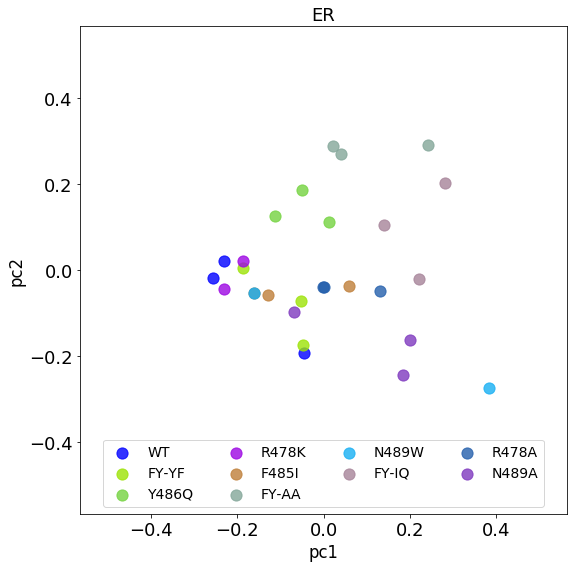

In [9]:
# Create figure
fig, axs = plt.subplots(1,1,figsize=[8,8])

#for panel_num, restrict in enumerate(['ars416','ars317', None]):
    # Set panel number
ax = axs
tmp_df = data_df[data_df['ars']=='ars416'].copy()
#tmp_df = data_df.copy()

# Perform restriction
#if restrict=='ars416' or restrict=='ars317':
#    tmp_df = data_df[data_df['ars']==restrict].copy()
#else:
#    tmp_df = data_df.copy()

# Do PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(tmp_df.loc[:,data_cols])

# Create pca_df with both pcs and info
pattern = '(exp.)_(ars[0-9]+)_([a-z0-9]+)_(.*)'
pca_cols = ['pc1','pc2']
pca_df = pd.DataFrame(data=pcs, columns=pca_cols, index=tmp_df.index)
pca_df = pd.concat([tmp_df[info_cols], pca_df], axis=1)

# Create sorted list of strains
strain_list = list(set(pca_df['strain']))
strain_list.sort()
print(strain_list)
print('There are %d strains'%len(strain_list))

# randomly generated
colors_list = [ 
                [0.0, 0.0, 1.0], # WT
                [0.61252607, 0.89187607, 0.02175532],    # F485Y,Y486F
                [0.45630455, 0.82612284, 0.25137413],    # Y486Q
                [0.61252607, 0.02175532, 0.89187607],    # R478K
                [0.74880388, 0.49850701, 0.22479665],    # F485I
                [0.51313824, 0.65039718, 0.60103895],    # F485A,Y486A

                [0.08833981, 0.68535982, 0.95339335],    # N489W
                [0.65039718, 0.51313824, 0.60103895],    # F485I,Y486Q
                
                [0.14217005, 0.37334076, 0.67413362],    # R478A
                [0.49850701, 0.22479665, 0.74880388],    # N489A
]
#groups_to_show = ['wt', 'm22']

# Get default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#colors = colors + ['k']

#print(strain_list)
strain_list = ['wt','m23','m1','m20','m3','m21','m6','m22','m9','m5']
mutant_labels = ['WT','FY-YF','Y486Q','R478K','F485I', 'FY-AA','N489W','FY-IQ', 'R478A','N489A',]

# Cycle through strains
for i, strain in enumerate(strain_list):
    # Get indices
    indices = (pca_df['strain']==strain) 
    tmp2_df = pca_df.loc[indices,:]
    ax.scatter(x=tmp2_df['pc1'],y=tmp2_df['pc2'], label=mutant_labels[i], color=colors_list[i], alpha=.8, s=125)

# Set lims
xs = pca_df['pc1'].values
ys = pca_df['pc2'].values
rmax = max(np.sqrt(xs**2+ys**2))
lims = [-1.2*rmax, +1.2*rmax]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
plt.yticks(np.arange(-0.4,0.6,0.2))
plt.xticks(np.arange(-0.4,0.6,0.2))

# Style plot
#if restrict is not None:
#    ax.set_title(restrict)
#else:
#    ax.set_title('ars416 and ars317')
#ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.4), ncol=4)
ax.legend(loc='lower center', ncol=4,fontsize=14)
ax.set_xlabel('pc1',fontsize=16.5)
ax.set_ylabel('pc2',fontsize=16.5)

plt.tick_params(labelsize=18)    
plt.title('ER',fontsize=18)
plt.tight_layout()

#plt.savefig('pca_ER.png')

['m1', 'm20', 'm21', 'm22', 'm23', 'm3', 'm5', 'm6', 'm9', 'wt']
There are 10 strains
['m1', 'm20', 'm21', 'm22', 'm23', 'm3', 'm5', 'm6', 'm9', 'wt']
There are 10 strains
['m1', 'm20', 'm21', 'm22', 'm23', 'm3', 'm5', 'm6', 'm9', 'wt']
There are 10 strains


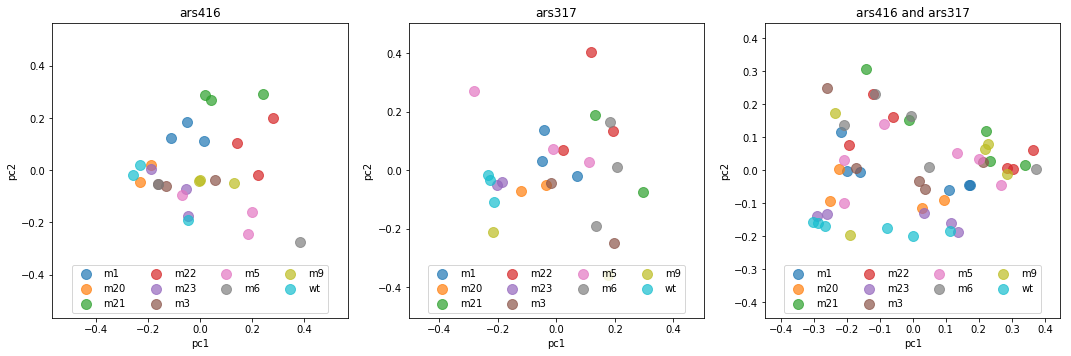

In [10]:
# Create figure
fig, axs = plt.subplots(1,3,figsize=[15,5])

for panel_num, restrict in enumerate(['ars416','ars317', None]):
    # Set panel number
    ax = axs[panel_num]

    # Perform restriction
    if restrict=='ars416' or restrict=='ars317':
        tmp_df = data_df[data_df['ars']==restrict].copy()
    else:
        tmp_df = data_df.copy()

    # Do PCA
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(tmp_df.loc[:,data_cols])

    # Create pca_df with both pcs and info
    pattern = '(exp.)_(ars[0-9]+)_([a-z0-9]+)_(.*)'
    pca_cols = ['pc1','pc2']
    pca_df = pd.DataFrame(data=pcs, columns=pca_cols, index=tmp_df.index)
    pca_df = pd.concat([tmp_df[info_cols], pca_df], axis=1)

    # Create sorted list of strains
    strain_list = list(set(pca_df['strain']))
    strain_list.sort()
    print(strain_list)
    print('There are %d strains'%len(strain_list))

    # Get default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #colors = colors + ['k']

    # Cycle through strains
    for i, strain in enumerate(strain_list):
        # Get indices
        indices = (pca_df['strain']==strain) 
        tmp2_df = pca_df.loc[indices,:]
        ax.scatter(x=tmp2_df['pc1'],y=tmp2_df['pc2'], label=strain, color=colors[i], alpha=.7, s=100)

    # Set lims
    xs = pca_df['pc1'].values
    ys = pca_df['pc2'].values
    rmax = max(np.sqrt(xs**2+ys**2))
    lims = [-1.2*rmax, +1.2*rmax]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
        
    # Style plot
    if restrict is not None:
        ax.set_title(restrict)
    else:
        ax.set_title('ars416 and ars317')
    #ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.4), ncol=4)
    ax.legend(loc='lower center', ncol=4)
    ax.set_xlabel('pc1')
    ax.set_ylabel('pc2')
    
plt.tight_layout()
#plt.savefig('pca_ER.png')

## Put everything in one plot

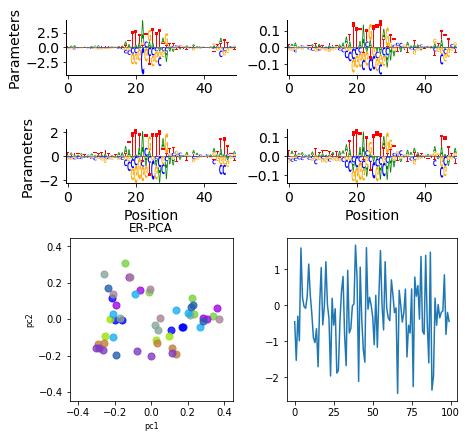

In [20]:
dfs_list = [-tmp_df7_ER,tmp_df7,-tmp_df8_ER,tmp_df8]
fig = plt.figure(figsize=[7,7])
gs = gridspec.GridSpec(4,2,hspace=1,wspace=0.3)

plt.tick_params(axis='both', which='major', labelsize=14)

column_index = 0
row_index = 0

for logo in dfs_list:
                      
    ax = plt.subplot(gs[column_index,row_index ])
    
    ax.tick_params(labelsize=14)
    current_logo = logomaker.Logo(logo, ax=ax, show_spines=False)    
    current_logo.style_spines(spines=['left', 'bottom'], visible=True)
    
    if row_index==0:        
        ax.set_ylabel('Parameters',fontsize=14)
    if column_index==1:
        ax.set_xlabel('Position',fontsize=14)
    
    if row_index ==1:
        column_index=1
        row_index=0
    else:
        row_index+=1
        
        
        
        
ax = plt.subplot(gs[2:,0])        

for i, strain in enumerate(strain_list):
    # Get indices
    indices = (pca_df['strain']==strain) 
    tmp2_df = pca_df.loc[indices,:]
    ax.scatter(x=tmp2_df['pc1'],y=tmp2_df['pc2'], label=mutant_labels[i], color=colors_list[i], alpha=.8, s=50)


# Set lims
xs = pca_df['pc1'].values
ys = pca_df['pc2'].values
rmax = max(np.sqrt(xs**2+ys**2))
lims = [-1.2*rmax, +1.2*rmax]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')

#ax.legend(loc='lower center', ncol=4)
ax.set_xlabel('pc1',fontsize=8)
ax.set_ylabel('pc2',fontsize=8)
plt.title('ER-PCA')

ax = plt.subplot(gs[2:,1])        
ax.plot(np.random.randn(100))

        
#plt.tight_layout()    
#plt.text(-58.5, 0.7, '(a)', fontsize=15)
#plt.text(-1, 0.7, '(b)', fontsize=15)

#plt.savefig('Fig_S1.png')


In [33]:
len(pca_df)

17